# 스마트공장 길라잡이 - 인공지능 비전인식

## [공통] 파이썬 설치

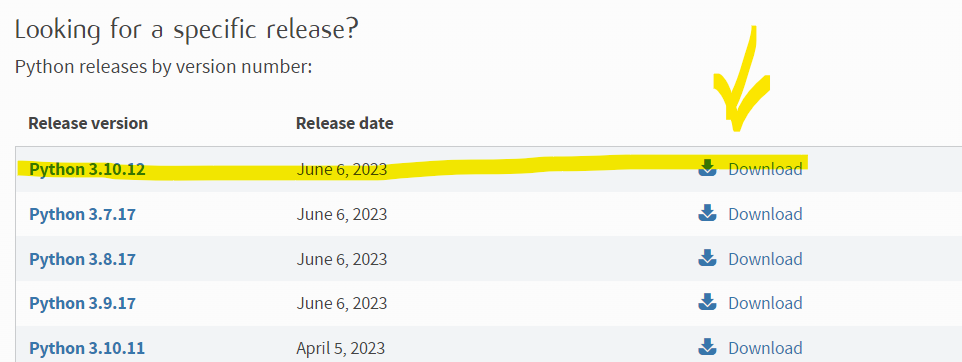

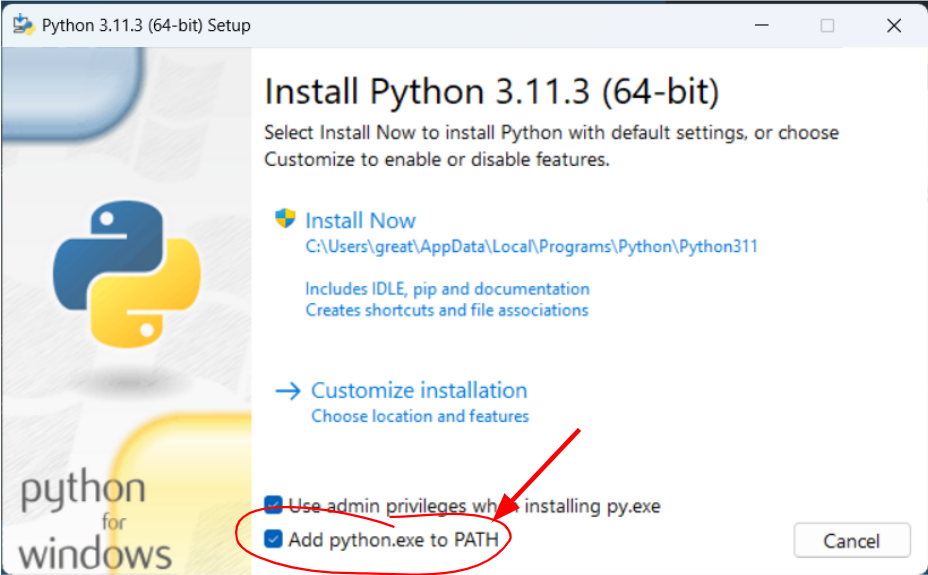

## 1. 라이브러리 설치

a. Opencv - Open Computer Vision Library

(컴퓨터 비전에 필요한 거의 모든 기능)

In [ ]:
%pip install opencv-python

- 혹시 이게 필요할지도... Set-ExecutionPolicy Unrestricted

## 2. 웹캠 테스트

In [ ]:
import cv2

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

while True:
    ret, frame = cap.read()
    if ret:
        cv2.imshow("webcam test", frame)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## 3. 이미지 분류 프로그램 사용

외부 링크를 클릭: https://teachablemachine.withgoogle.com

## 4. 공개된 학습모델을 데스트해보자.

이미 학습된 모델이 있습니다. 이걸 다운로드 받아서 한번 실행해봅시다. 도대체 무슨 일이 일어나는지 우리 눈으로 직접 봅시다.

In [4]:
import urllib.request

# weights 파일을 다운받기
url = 'https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights'
file_name = 'coco_model/yolov4-tiny.weights'

urllib.request.urlretrieve(url, file_name)

# cfg 파일을 다운받기
url = 'https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg'
file_name = 'coco_model/yolov4-tiny.cfg'

urllib.request.urlretrieve(url, file_name)

# coco.names 파일을 다운받기
url = 'https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/coco.names'
file_name = 'coco_model/coco.names'

urllib.request.urlretrieve(url, file_name)


('coco_model/coco.names', <http.client.HTTPMessage at 0x1bc3a28f1c0>)

다운로드가 다 되었으면, 아래 코드를 실행해 봅시다.

카메라를 움직여서 (혹은 카메라 앞에 얼쩡거려서..) 화면에 어떤 정보가 나타나는지 확인해봅시다.

우리 일상에서 쉽게 볼 수 있는 사물들을 카메라에게 보여주세요.

In [6]:
import cv2
import numpy as np

def do_object_detection(frame, names_file, output_layers):
    # read names file
    with open(names_file, 'r') as nf:
        names = nf.readlines()

    # Perform object detection
    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Process the detected objects
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw bounding boxes and labels
    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0, 255, size=(len(class_ids), 3))
    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = names[class_ids[i]].strip()
            confidence = str(round(confidences[i], 2))
            color = colors[i]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label + " " + confidence, (x, y + 20), font, 2, (0, 255, 0), 2)

    return frame

net = cv2.dnn.readNetFromDarknet("coco_model/yolov4-tiny.cfg", "coco_model/yolov4-tiny.weights")

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

video_capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)

while True:
    # Read a frame from the webcam
    ret, frame = video_capture.read()
    frame = do_object_detection(frame, "coco_model/coco.names", output_layers)

    # Display the resulting frame
    cv2.imshow("Object Detection", frame)

    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
video_capture.release()
cv2.destroyAllWindows()


## 5. 나만의 (우리회사만의) 비전인식 시스템을 만들어보자.

[반드시 실행] 아래의 코드들을 실행하기 위해서 꼭 필요한 내용

In [2]:
data_folder = "my_data"
destination_folder = "ziptempdel"

a. 사진촬영 (혹은 사진을 다운받아서?)

In [8]:
import os, zipfile, shutil, datetime
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askdirectory

def unzip_file(zip_path, destination_folder):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)
    print("Unzip completed successfully.")

if not os.path.exists(data_folder):
    os.mkdir(data_folder)

# Create a Tkinter root window
root = Tk()
root.withdraw()

# jpg 파일들이 압축되어 있는 파일을 선택하기
file_path = askopenfilename(filetypes=[("ZIP Files", "*.zip")])

if file_path:
    # 압축 풀기
    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)
    os.mkdir(destination_folder)
    unzip_file(file_path, destination_folder)

    # 10 KB 보다 크기가 작은 파일을 모두 삭제
    file_list = os.listdir(destination_folder)
    for file_name in file_list:
        file_path = os.path.join(destination_folder, file_name)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path)
            if file_size < 10000:
                os.remove(file_path)

    # .jpg 파일만 남기고 나머지는 모두 삭제
    file_list = os.listdir(destination_folder)
    for file_name in file_list:
        file_path = os.path.join(destination_folder, file_name)
        if os.path.isfile(file_path) and not file_name.endswith('.jpg'):
            os.remove(file_path)

    # 구구각각인 파일 이름을 단순화 (1, 2, 3 ...)
    file_list = os.listdir(destination_folder)
    ndx = 0
    f_prefix = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for source_file in file_list:
        old_name = os.path.join(destination_folder, source_file)
        new_name = os.path.join(destination_folder, f_prefix + "_" + str(ndx) + ".jpg")
        os.rename(old_name, new_name)
        ndx += 1

    # 나의 데이터 폴더에 정리된 사진을 이동
    if not os.path.exists(data_folder):
        os.mkdir(data_folder)
    file_list = os.listdir(destination_folder)
    for file_name in file_list:
        source_file = os.path.join(destination_folder, file_name)
        move_file = os.path.join(data_folder, file_name)
        shutil.move(source_file, move_file)

    shutil.rmtree(destination_folder)

Unzip completed successfully.


b. 라벨링 (음... 노가다)

In [9]:
# 먼저 obj.names 파일을 만든다.
names = ["biden", "obama", "trump", "me"]     # 클래스 설정

with open(data_folder + "/obj.names", 'w') as nf:
    for name in names:
        nf.write(name + "\n")

In [ ]:
# 라벨링 프로그램을 설치한다.
%pip install labelme

In [3]:
# 라벨링 프로그램을 구동한다.
import subprocess

subprocess.run(["labelme", data_folder, 
                "--labels", data_folder + "/obj.names", 
                "--autosave", "--nodata"])      

CompletedProcess(args=['labelme', 'my_data', '--labels', 'my_data/obj.names', '--autosave', '--nodata'], returncode=0)

c. 학습 (train) - 이걸 위해서는 꽤 괜찮은 GPU가 필요합니다. 이건 그냥 전문적인 컴퓨터에 맡겨둡시다.

> - 라벨링 결과인 json 파일의 내용을 해석해서 txt 파일로 바꿔준다.
> - 이미지 파일 목록을 만든다
> - 모델 학습 중에 "계산"에 쓸 파일과 "검증"에 쓸 파일을 나눈다. (보통 8:2 정도로 나눈다.)
> - 내가 준비한 데이터의 상황에 맞게 cnf 파일을 수정한다.
> - 그리고 학습을 시작한다... (2시간 ~ 2일)

d. 테스트 - 학습이 끝나면 weights 파일과 cfg 파일을 다운받아서 실제 인식작업이 잘 되는지 확인해봅니다.

In [17]:
# 학습이 끝난 파일을 다운받는다.

import urllib.request

# weights 파일을 다운받기
url = 'https://raw.githubusercontent.com/greathtj/greathtj/main/yolov4-tiny-custom_last.weights'
file_name = 'face_model/yolov4-tiny-custom_last.weights'

urllib.request.urlretrieve(url, file_name)

# cfg 파일을 다운받기
url = 'https://raw.githubusercontent.com/greathtj/greathtj/main/yolov4-tiny-custom.cfg'
file_name = 'face_model/yolov4-tiny-custom.cfg'

urllib.request.urlretrieve(url, file_name)

# obj.names 파일을 다운받기
url = 'https://raw.githubusercontent.com/greathtj/greathtj/main/obj.names'
file_name = 'face_model/obj.names'

urllib.request.urlretrieve(url, file_name)

('face_model/obj.names', <http.client.HTTPMessage at 0x1bc4b6a2c20>)

In [20]:
import cv2
import numpy as np

def do_object_detection(frame, names_file, output_layers):
    # read names file
    with open(names_file, 'r') as nf:
        names = nf.readlines()

    # Perform object detection
    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Process the detected objects
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw bounding boxes and labels
    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0, 255, size=(len(class_ids), 3))
    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = names[class_ids[i]].strip()
            confidence = str(round(confidences[i], 2))
            color = colors[i]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label + " " + confidence, (x, y + 20), font, 2, (0, 255, 0), 2)

    return frame

net = cv2.dnn.readNetFromDarknet("face_model/yolov4-tiny-custom.cfg", "face_model/yolov4-tiny-custom_last.weights")

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

video_capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)

while True:
    # Read a frame from the webcam
    ret, frame = video_capture.read()
    frame = do_object_detection(frame, "face_model/obj.names", output_layers)

    # Display the resulting frame
    cv2.imshow("Object Detection", frame)

    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
video_capture.release()
cv2.destroyAllWindows()


## 6. [추가작업]

a. 사진 촬영기를 만들 수 있을까?

b. 뭘 촬영하는지 자동으로 기록을 남길 수 있을까?

c. 구글 코랩 이용하기... (https://colab.research.google.com)